# IMPORTS

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import SGDClassifier

# UTILS

In [3]:
def split_training_validation(X, Y, validation_proportion=10):
    indices = [i for i in range(X.shape[0])] # Observations as rows of X
    np.random.shuffle(indices)
    split = int(X.shape[0] * validation_proportion / 100)
    train_indices, validation_indices = indices[:split], indices[split:]
    X_train, Y_train = X[train_indices], Y[train_indices]
    X_validation, Y_validation = X[validation_indices], Y[validation_indices]
    return X_train, Y_train, X_validation, Y_validation

def show_grid_images(images, title=''):
    """
    From a list of images,
    Plots all images along a kx5 grid.
    """
    nbr_images = images.shape[0]
    figsize_ref = 2
    rows, columns = int(nbr_images / 5), 5
    f = plt.figure(figsize=(figsize_ref*columns,figsize_ref*rows)) # 2 Columns, . Lines
    plt.axis('off')
    plt.title(title,  y=1.08) # Trick to offset the title.
    plt.subplots_adjust(wspace=-0.35, hspace=0)
    for index in range(nbr_images):
        image = images[index]
        ax = f.add_subplot(rows, columns, index + 1)
        ax.axis('off')
        ax.imshow(image, cmap=plt.cm.gray)
    
    plt.show()

# LOADING DATASETS

In [197]:
def load_dataset(dataset_name, path='./data/'):
    dataset = np.load(f'{path}{dataset_name}')
    X_train, Y_train = dataset['Xtr'], dataset['Str']
    X_test, Y_test = dataset['Xts'], dataset['Yts']
    
    return X_train, Y_train, X_test, Y_test

### ======================

In [198]:
MNIST_05_NAME = 'FashionMNIST0.5.npz'
MNIST_06_NAME = 'FashionMNIST0.6.npz'
CIFAR_NAME = 'CIFAR.npz'

mnist05_X_train, mnist05_Y_train, mnist05_X_test, mnist05_Y_test = load_dataset(MNIST_05_NAME)
print('Fashion MNIST 0.5 dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(mnist05_X_train.shape, mnist05_X_test.shape, set(mnist05_Y_train)))
mnist06_X_train, mnist06_Y_train, mnist06_X_test, mnist06_Y_test = load_dataset(MNIST_06_NAME)
print('Fashion MNIST 0.6 dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(mnist06_X_train.shape, mnist06_X_test.shape, set(mnist06_Y_train)))
cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test = load_dataset(CIFAR_NAME)
print('Fashion CIFAR dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(cifar_X_train.shape, cifar_X_test.shape, set(cifar_Y_train)))


Fashion MNIST 0.5 dataset, X_train shape: (18000, 28, 28), X_test shape: (3000, 28, 28), Classes in Y: {0, 1, 2}
Fashion MNIST 0.6 dataset, X_train shape: (18000, 28, 28), X_test shape: (3000, 28, 28), Classes in Y: {0, 1, 2}
Fashion CIFAR dataset, X_train shape: (15000, 32, 32, 3), X_test shape: (3000, 32, 32, 3), Classes in Y: {0, 1, 2}


In [34]:
# Transitions Matrices
mnist05_X_T = np.array([
    [0.5, 0.3, 0.2],
    [0.2, 0.5, 0.3],
    [0.3, 0.2, 0.5]
])

mnist06_X_T = np.array([
    [0.4, 0.3, 0.4],
    [0.4, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])

## Image Visualization

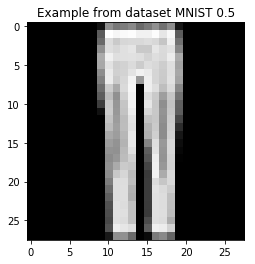

Associated Class: trousers


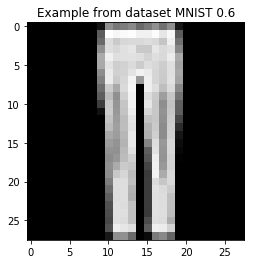

Associated Class: trousers


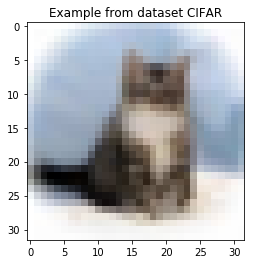

Associated Class: 0


In [41]:
# Fashion MNIST 0.5
plt.figure()
plt.imshow(mnist05_X_train[66], cmap=plt.cm.gray)
plt.title('Example from dataset MNIST 0.5')
plt.show()
print(f'Associated Class: {mnist_classes[mnist05_Y_train[66]]}')


# Fashion MNIST 0.6
plt.figure()
plt.imshow(mnist06_X_train[66], cmap=plt.cm.gray)
plt.title('Example from dataset MNIST 0.6')
plt.show()
print(f'Associated Class: {mnist_classes[mnist06_Y_train[66]]}')

# Fashion CIFAR
plt.figure()
plt.imshow(cifar_X_train[66], cmap=plt.cm.gray)
plt.title('Example from dataset CIFAR')
plt.show()
print(f'Associated Class: {cifar_Y_train[66]}')

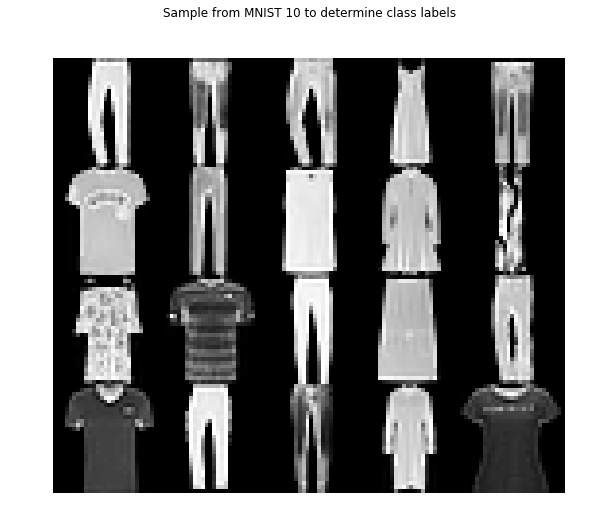

Associated Labels
[[1 1 1 2 1]
 [0 1 0 2 2]
 [2 0 1 2 1]
 [0 1 1 2 0]]


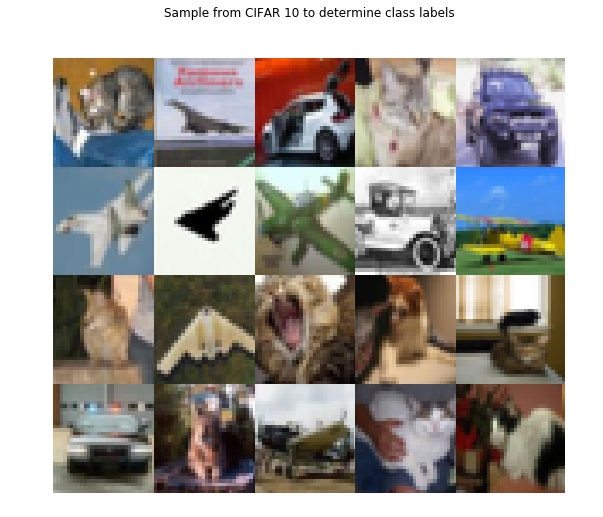

Associated Labels
[[2 0 1 2 1]
 [0 0 0 1 0]
 [2 0 2 2 2]
 [1 2 0 2 2]]


In [46]:
nbr_examples = 20
show_grid_images(mnist05_X_test[:nbr_examples], 'Sample from MNIST 10 to determine class labels')
print('Associated Labels')
print(mnist05_Y_test[:nbr_examples].reshape(-1,5))

nbr_examples = 20
show_grid_images(cifar_X_test[:nbr_examples], 'Sample from CIFAR 10 to determine class labels')
print('Associated Labels')
print(cifar_Y_test[:nbr_examples].reshape(-1,5))

In [48]:
mnist_classes = ['t-shirt', 'trousers', 'dress']
cifar_classes = ['plane', 'car', 'cat']

#### Evidence of Label Noise

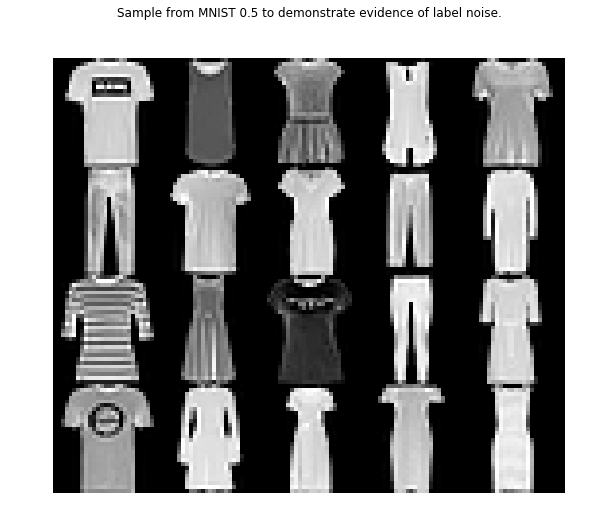

Associated Labels
[['dress' 'trousers' 'dress' 'trousers' 'dress']
 ['t-shirt' 'trousers' 't-shirt' 'trousers' 't-shirt']
 ['trousers' 'trousers' 'trousers' 'dress' 'dress']
 ['t-shirt' 'dress' 'dress' 'dress' 'dress']]


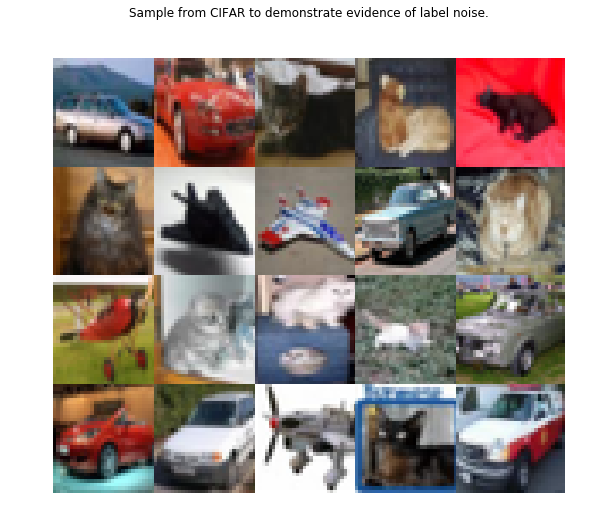

Associated Labels
[['car' 'cat' 'plane' 'cat' 'car']
 ['plane' 'plane' 'plane' 'car' 'plane']
 ['cat' 'cat' 'plane' 'plane' 'car']
 ['car' 'cat' 'plane' 'car' 'car']]


In [49]:
nbr_examples = 20
show_grid_images(mnist05_X_train[:nbr_examples], 'Sample from MNIST 0.5 to demonstrate evidence of label noise.')
print('Associated Labels')
print(np.array([mnist_classes[mnist05_Y_train[i]] for i in range(nbr_examples)]).reshape(-1,5))

show_grid_images(cifar_X_train[:nbr_examples], 'Sample from CIFAR to demonstrate evidence of label noise.')
print('Associated Labels')
print(np.array([cifar_classes[cifar_Y_train[i]] for i in range(nbr_examples)]).reshape(-1,5))

## Resizing datasets

In [51]:
# MNIST 0.5
mnist_image_size = [28, 28]
mnist05_X_train = mnist05_X_train.reshape(-1, np.prod(mnist_image_size))
mnist05_X_test = mnist05_X_test.reshape(-1, np.prod(mnist_image_size))

# MNIST 0.6
mnist06_X_train = mnist06_X_train.reshape(-1, np.prod(mnist_image_size))
mnist06_X_test = mnist06_X_test.reshape(-1, np.prod(mnist_image_size))

# CIFAR
cifar_image_size = [3, 32, 32]
cifar_X_train = cifar_X_train.reshape(-1, np.prod(cifar_image_size))
cifar_X_test = cifar_X_test.reshape(-1, np.prod(cifar_image_size))

#  CLASSIFICATION

In [56]:
# Using SK Learn for validation of idea
clf = SGDClassifier(loss='log', alpha=0.3) # modified_huber
clf.fit(mnist05_X_train, mnist05_Y_train)

SGDClassifier(alpha=0.3, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
noisy_probas = clf.predict_proba(mnist05_X_train)
true_probas = noisy_probas@np.linalg.pinv(mnist05_X_T).T
predicted_classes = np.argmax(true_probas, axis=1) # flipped classes
p_classes = clf.predict(mnist05_X_train) # original classes

accuracy(mnist05_Y_train, p_classes), accuracy(mnist05_Y_train, predicted_classes)

(45.6, 44.88333333333333)

# FLIP

# EVALUATION

In [24]:
def accuracy(true_labels, predicted_labels):
    correct = 0
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            correct += 1
    return correct / len(true_labels) * 100
        

In [57]:
accuracy(mnist05_Y_train, clf.predict(mnist05_X_train)), accuracy(mnist05_Y_test, clf.predict(mnist05_X_test))

(45.6, 59.13333333333334)

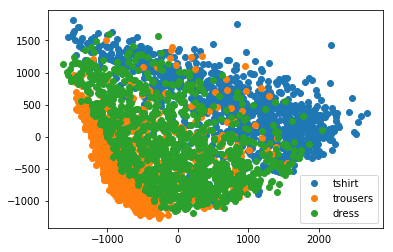

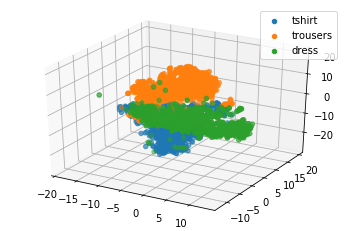

In [68]:
# TEST PCA & TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pca = PCA(n_components=2)
pca_outputs = pca.fit_transform(mnist05_X_test, mnist05_Y_test)

tshirt_mask = (mnist05_Y_test == 0)
pca_tshirt = pca_outputs[tshirt_mask]

trousers_mask = (mnist05_Y_test == 1)
pca_trousers = pca_outputs[trousers_mask]

dress_mask = (mnist05_Y_test == 2)
pca_dress = pca_outputs[dress_mask]

plt.figure()
plt.plot(pca_tshirt[:,0],pca_tshirt[:,1], 'o')
plt.plot(pca_trousers[:,0],pca_trousers[:,1], 'o')
plt.plot(pca_dress[:,0],pca_dress[:,1], 'o')
plt.legend(['tshirt', 'trousers', 'dress'])
plt.show()


tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=1000)
tsne_outputs = tsne.fit_transform(mnist05_X_test, mnist05_Y_test)

tsne_tshirt = tsne_outputs[tshirt_mask]

tsne_trousers = tsne_outputs[trousers_mask]

tsne_dress = tsne_outputs[dress_mask]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_tshirt[:,0], tsne_tshirt[:,1], tsne_tshirt[:,2])
ax.scatter(tsne_trousers[:,0], tsne_trousers[:,1], tsne_trousers[:,2])
ax.scatter(tsne_dress[:,0], tsne_dress[:,1], tsne_dress[:,2])
ax.legend(['tshirt', 'trousers', 'dress'])
plt.show()

# Label Noise Robust NN

In [143]:
# Imports
import cv2
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, TensorDataset

 ---- Source Samples
trousers t-shirt trousers trousers trousers t-shirt trousers dress trousers trousers dress trousers trousers dress


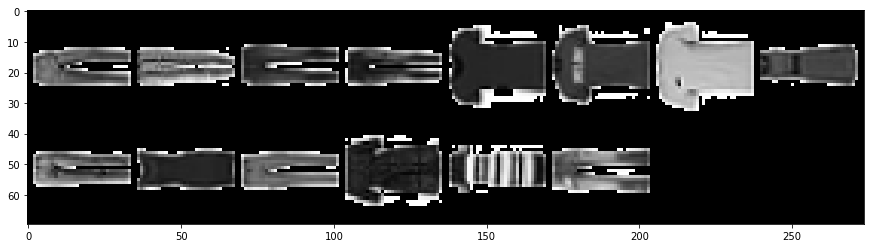

In [151]:
# Utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing
def grayscale_to_rgb(grayscale_dataset):
    """
    input dim: NxWxH
    output dim: NxWxHx3
    """
    return np.stack((grayscale_dataset,)*3, axis=-1)

def resize(X, image_size):
    resized_X = np.zeros((X.shape[0], image_size[0], image_size[1], X.shape[-1]))
    for i in range(X.shape[0]):
        resized_X[i, :, :, :] = cv2.resize(X[i, :, :, :], image_size, interpolation = cv2.INTER_AREA)
    return resized_X

def swap_channel_axis(X):
    """
    input dim: NxWxHx3
    output dim: Nx3xWxH
    """
    return np.swapaxes(X, -1, 1)

def normalize_per_channel(X):
    """
    input dim: Nx3xWxH
    """
    means, stds = [], []
    for channel in range(X.shape[1]):
        mean, std = X[:, channel, :, :].mean(), X[:, channel, :, :].std()
        X[:, channel, :, :] = (X[:, channel, :, :] - mean) / std
        means.append(mean)
        stds.append(std)
    return X, {"mean": means, "std": stds}
        
def unnormalize(x, mean, std):
    x = x * np.array(std).reshape(x.shape[0], 1, 1) + np.array(mean).reshape(x.shape[0], 1, 1)
    return x

def showimg(tensor, normalization=None):
    npimg = tensor.numpy()
    if normalization:
        npimg = unnormalize(npimg, normalization['mean'], normalization['std'])
    plt.figure(figsize=(15,10))
    plt.imshow((np.transpose(npimg, (1, 2, 0))* 255).astype(np.uint8))
    plt.show()






 ---- Source Samples
plane   cat plane   cat   cat   cat   car   cat plane plane   car   cat plane   car


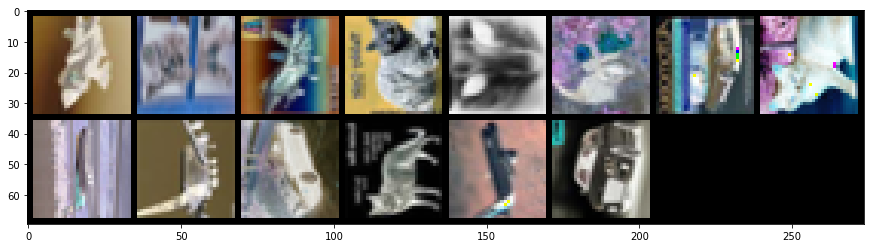

In [153]:
# Data Loaders

# MNIST 05
mnist05_X_train_rgb = grayscale_to_rgb(mnist05_X_train)
mnist05_X_train_rgb = resize(mnist05_X_train_rgb, (32, 32))
mnist05_X_train_rgb = swap_channel_axis(mnist05_X_train_rgb)
mnist05_train_set = TensorDataset(torch.from_numpy(mnist05_X_train_rgb), torch.from_numpy(mnist05_Y_train))

mnist05_X_test_rgb = grayscale_to_rgb(mnist05_X_test)
mnist05_X_test_rgb = resize(mnist05_X_test_rgb, (32, 32))
mnist05_X_test_rgb = swap_channel_axis(mnist05_X_test_rgb)
mnist05_test_set = TensorDataset(torch.from_numpy(mnist05_X_test_rgb), torch.from_numpy(mnist05_Y_test))


# MNIST 06
mnist06_X_train_rgb = grayscale_to_rgb(mnist06_X_train)
mnist06_X_train_rgb = resize(mnist06_X_train_rgb, (32, 32))
mnist06_X_train_rgb = swap_channel_axis(mnist06_X_train_rgb)
mnist06_train_set = TensorDataset(torch.from_numpy(mnist06_X_train_rgb), torch.from_numpy(mnist06_Y_train))

mnist06_X_test_rgb = grayscale_to_rgb(mnist06_X_test)
mnist06_X_test_rgb = resize(mnist06_X_test_rgb, (32, 32))
mnist06_X_test_rgb = swap_channel_axis(mnist06_X_test_rgb)
mnist06_test_set = TensorDataset(torch.from_numpy(mnist06_X_test_rgb), torch.from_numpy(mnist06_Y_test))


# CIFAR
cifar_X_train = swap_channel_axis(cifar_X_train)
cifar_train_set = TensorDataset(torch.from_numpy(cifar_X_train), torch.from_numpy(cifar_Y_train))

cifar_X_test = swap_channel_axis(cifar_X_test)
cifar_test_set = TensorDataset(torch.from_numpy(cifar_X_test), torch.from_numpy(cifar_Y_test))



# Visualization test
mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=14, shuffle=True)
dataiter = mnist05_test_loader.__iter__()
input, labels = dataiter.next()
print(' ---- Source Samples')
print(' '.join('%5s' % mnist_classes[labels[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(input), normalization=None)

In [82]:
# Model structure

class CNN(nn.Module):

    def __init__(self, number_classes=10):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0), # 28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), # 5
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(5*5*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, number_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 5 * 5)
        x = self.classifier(x)
        return x
    
TEST_INPUT = True
if TEST_INPUT:
    cnn_test = CNN()
    INPUT_SIZE = (3, 32, 32)
    input_random = torch.rand((1, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2])).to(device)
    print('Forward Test\n', cnn_test(input_random))

Forward Test
 tensor([[-0.0102, -0.0006,  0.0139,  0.0344,  0.0115,  0.0314, -0.0290,  0.0343,
         -0.0314,  0.0340]], grad_fn=<AddmmBackward>)


In [194]:
# Training and Evaluation


def train(model, optimizer, criterion, train_loader, test_loader, device, params, inverse_transition_matrix=None):
    """
    Assuming that the whole dataset can be loaded at once.
    """
    
    print('==== Start Training ====')
    # Train Flag
    model.train()
    
    for epoch in range(params.epochs):
        
        for iteration, (inputs, labels) in enumerate(train_loader):
            # Prepare to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Reset grad
            optimizer.zero_grad()

            # Outputs
            output_labels = model(inputs.float())

            # Loss
            if inverse_transition_matrix is not None:
                output_labels = (inverse_transition_matrix.float()@output_labels.transpose(0,1)).transpose(0,1)
            loss = criterion(output_labels, labels)

            # Optimize
            loss.backward()
            optimizer.step()
        
        print(epoch)
    
    return model
        
        
        
        

In [195]:
class Params(object):
    batch_size = 252
    epochs = 2
    learning_rate = 0.01
    momentum = 0.9
    weight_decay = 0

params = Params()
model = CNN(number_classes=3).to(device).float()
optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
criterion = nn.CrossEntropyLoss()

# ====================================
# Loaders
mnist05_train_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, shuffle=True)
mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=params.batch_size, shuffle=True)

mnist06_train_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, shuffle=True)
mnist06_test_loader = DataLoader(mnist06_test_set, batch_size=params.batch_size, shuffle=True)

cifar_train_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, shuffle=True)
cifar_test_loader = DataLoader(cifar_test_set, batch_size=params.batch_size, shuffle=True)

# ====================================
# Choose dataset and Transition Matrix
train_loader, test_loader = mnist05_train_loader, mnist05_test_loader
inverse_transition_matrix = torch.from_numpy(np.linalg.inv(mnist05_X_T))

In [196]:
model = train(model, optimizer, criterion, train_loader, test_loader, device, params, inverse_transition_matrix=inverse_transition_matrix)

==== Start Training ====


KeyboardInterrupt: 

# CLEANLAB BASELINE

In [ ]:
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.latent_estimation import estimate_latent
from cleanlab.latent_estimation import estimate_confident_joint_and_cv_pred_proba
from sklearn.linear_model import LogisticRegression

lnl = LearningWithNoisyLabels(clf=LogisticRegression())
lnl.fit(mnist05_X_train, mnist05_Y_train)
mnist05_Y_train_pred = lnl.predict(mnist05_X_train)
mnist05_Y_test_pred = lnl.predict(mnist05_X_train)

# Accuracy
print('Accuracies, train {}, test {}'.format(accuracy(mnist05_Y_train_pred, mnist05_Y_train), accuracy(mnist05_Y_test_pred, mnist05_Y_test)))

# Latent Variables Estimation
# Compute the confident joint and the n x m predicted probabilities matrix (psx),
# for n examples, m classes. Stop here if all you need is the confident joint.
confident_joint, psx = estimate_confident_joint_and_cv_pred_proba(
    X=mnist05_X_train,
    s=mnist05_Y_train,
    clf = LogisticRegression(), # default, you can use any classifier
)

# Estimate latent distributions: p(y) as est_py, P(s|y) as est_nm, and P(y|s) as est_inv
est_py, est_nm, est_inv = estimate_latent(confident_joint, s=mnist05_Y_train)

print('\n', confident_joint, '\n', psx, '\n', est_py, '\n', est_nm, '\n', est_inv)